<a href="https://colab.research.google.com/github/minddo/AboutDataMining/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [0]:
#connect to google dirve

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train=pd.read_csv('gdrive/My Drive/house-prices/train.csv')
test=pd.read_csv('gdrive/My Drive/house-prices/test.csv')

In [0]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [0]:
train_ID = train['Id']
test_ID = test['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

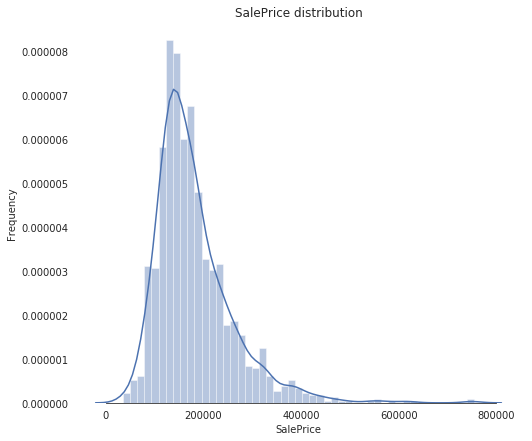

In [0]:
#Before the normalisation
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

# Deleting the more visibly obvious outliers
# 4500 exceeds the central tendecy of of the houses in that price point and all the houses in the dataset
# will deal with more subtle outlers later.
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)


 mu = 12.02 and sigma = 0.40



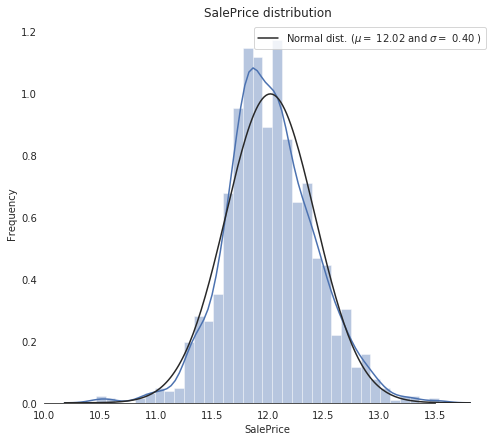

In [0]:
#We use the numpy fuction log1p 
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [0]:
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# concatinate the train and the test set as features for tranformation to avoid mismatch
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print('Features size:', features.shape)

Features size: (2917, 79)


In [0]:
# function for determining the threshold of missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

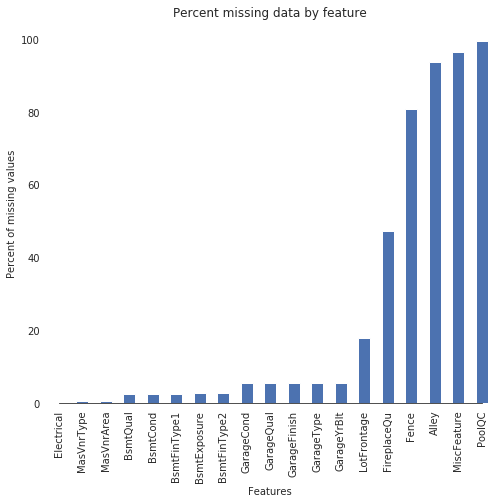

In [0]:
# visualising missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)


In [0]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# data description says NA means typical
features['Functional'] = features['Functional'].fillna('Typ')
# has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
features['Electrical'] = features['Electrical'].fillna("SBrkr")
#  Only one NA value, We set 'TA' (which is the most frequent) for the missing value in KitchenQual
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

# Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
# Fill in again with most frequent
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# data description says NA means "No Pool", majority of houses have no Pool at all in general.
features["PoolQC"] = features["PoolQC"].fillna("None")

# Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
# Replacing missing data with None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
# For all these categorical basement-related features, NaN means that there is no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print('Features size:', features.shape)

Features size: (2917, 79)


In [0]:
# Filling the rest of the categorical features
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

In [0]:
# Filling in the rest of the NA's
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [0]:
# Check the state of missing values
missing = percent_missing(features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

In [0]:
# First we need to find all numeric features in the data
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

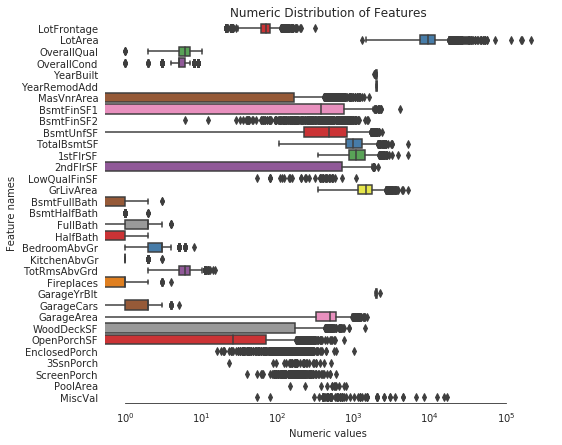

In [0]:
# Box plots for all our numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[numerics2] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [0]:
#Find the skewed  numerical features
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

In [0]:
# Normalise skewed features
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
    

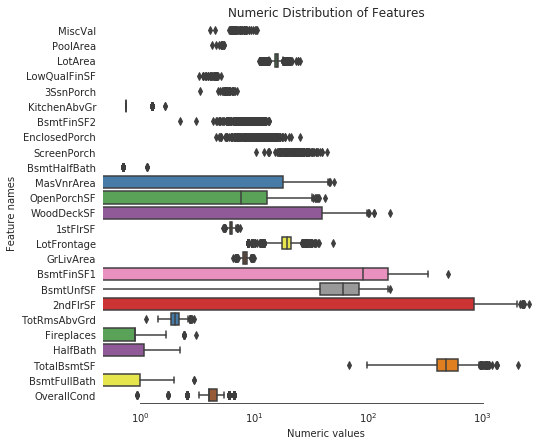

In [0]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[skew_index] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [0]:
# Calculating totals before droping less significant columns

#  Adding total sqfootage feature 
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
#  Adding total bathrooms feature
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
#  Adding total porch sqfootage feature
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [0]:
# Not normaly distributed can not be normalised and has no central tendecy
features = features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)

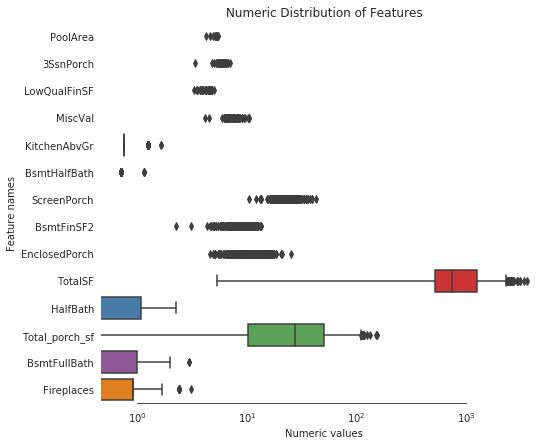

In [0]:
# Check the distribution after dopping the skewed features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics3 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics3.append(i)
        
skew_features = features[numerics3].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[skew_index] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [0]:
# Adding new simplified features (1 = present, 0 = not present)
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print('Features size:', features.shape)

Features size: (2917, 81)


In [0]:
# Encoding the finalized features
final_features = pd.get_dummies(features).reset_index(drop=True)
print('Features size:', features.shape)
final_features.head()

Features size: (2917, 81)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF,Total_Bathrooms,Total_porch_sf,haspool,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,...,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.287076,15.324634,7,4.009159,2003,2003,0.0,29.969715,422.744660,6.048096,0.0,8.507090,0.993468,0.000000,2,1.068837,3,0.753416,2.300030,0.000000,2003.0,2.0,548.0,0.000000,0.0,0.0,0.0,0.0,1454.472026,3.527886,12.093676,0,1,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20.844485,15.654145,6,6.033388,1976,1976,0.0,44.099726,594.272171,6.352506,0.0,8.117948,0.000000,0.710895,2,0.000000,3,0.753416,2.027391,0.903492,1976.0,2.0,460.0,0.000000,0.0,0.0,0.0,0.0,600.624677,2.355448,56.151041,0,1,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,18.816322,16.069417,7,4.009159,2001,2002,0.0,56.846811,450.355958,6.104964,0.0,8.563107,0.993468,0.000000,2,1.068837,3,0.753416,2.027391,0.903492,2001.0,2.0,608.0,0.000000,0.0,0.0,0.0,0.0,1497.009735,3.527886,9.911092,0,1,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,17.382411,15.640580,7,4.009159,1915,1970,0.0,64.750023,379.079390,6.139280,0.0,8.512349,0.993468,0.000000,1,0.000000,3,0.753416,2.171960,0.903492,1998.0,3.0,642.0,15.550921,0.0,0.0,0.0,0.0,1289.719653,1.993468,24.525688,0,1,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,21.492507,16.702121,8,4.009159,2000,2000,0.0,61.111774,545.656997,6.276613,0.0,8.831592,0.993468,0.000000,2,1.068837,4,0.753416,2.415027,0.903492,2000.0,3.0,836.0,0.000000,0.0,0.0,0.0,0.0,1824.993571,3.527886,56.511389,0,1,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [0]:
# Spliting the data back to train(X,y) and test(X_sub)
X = final_features.iloc[:len(y), :]
X_test = final_features.iloc[len(X):, :]
print('Features size for train(X,y) and test(X_test):')
print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

Features size for train(X,y) and test(X_test):
X (1458, 334) y (1458,) X_test (1459, 334)


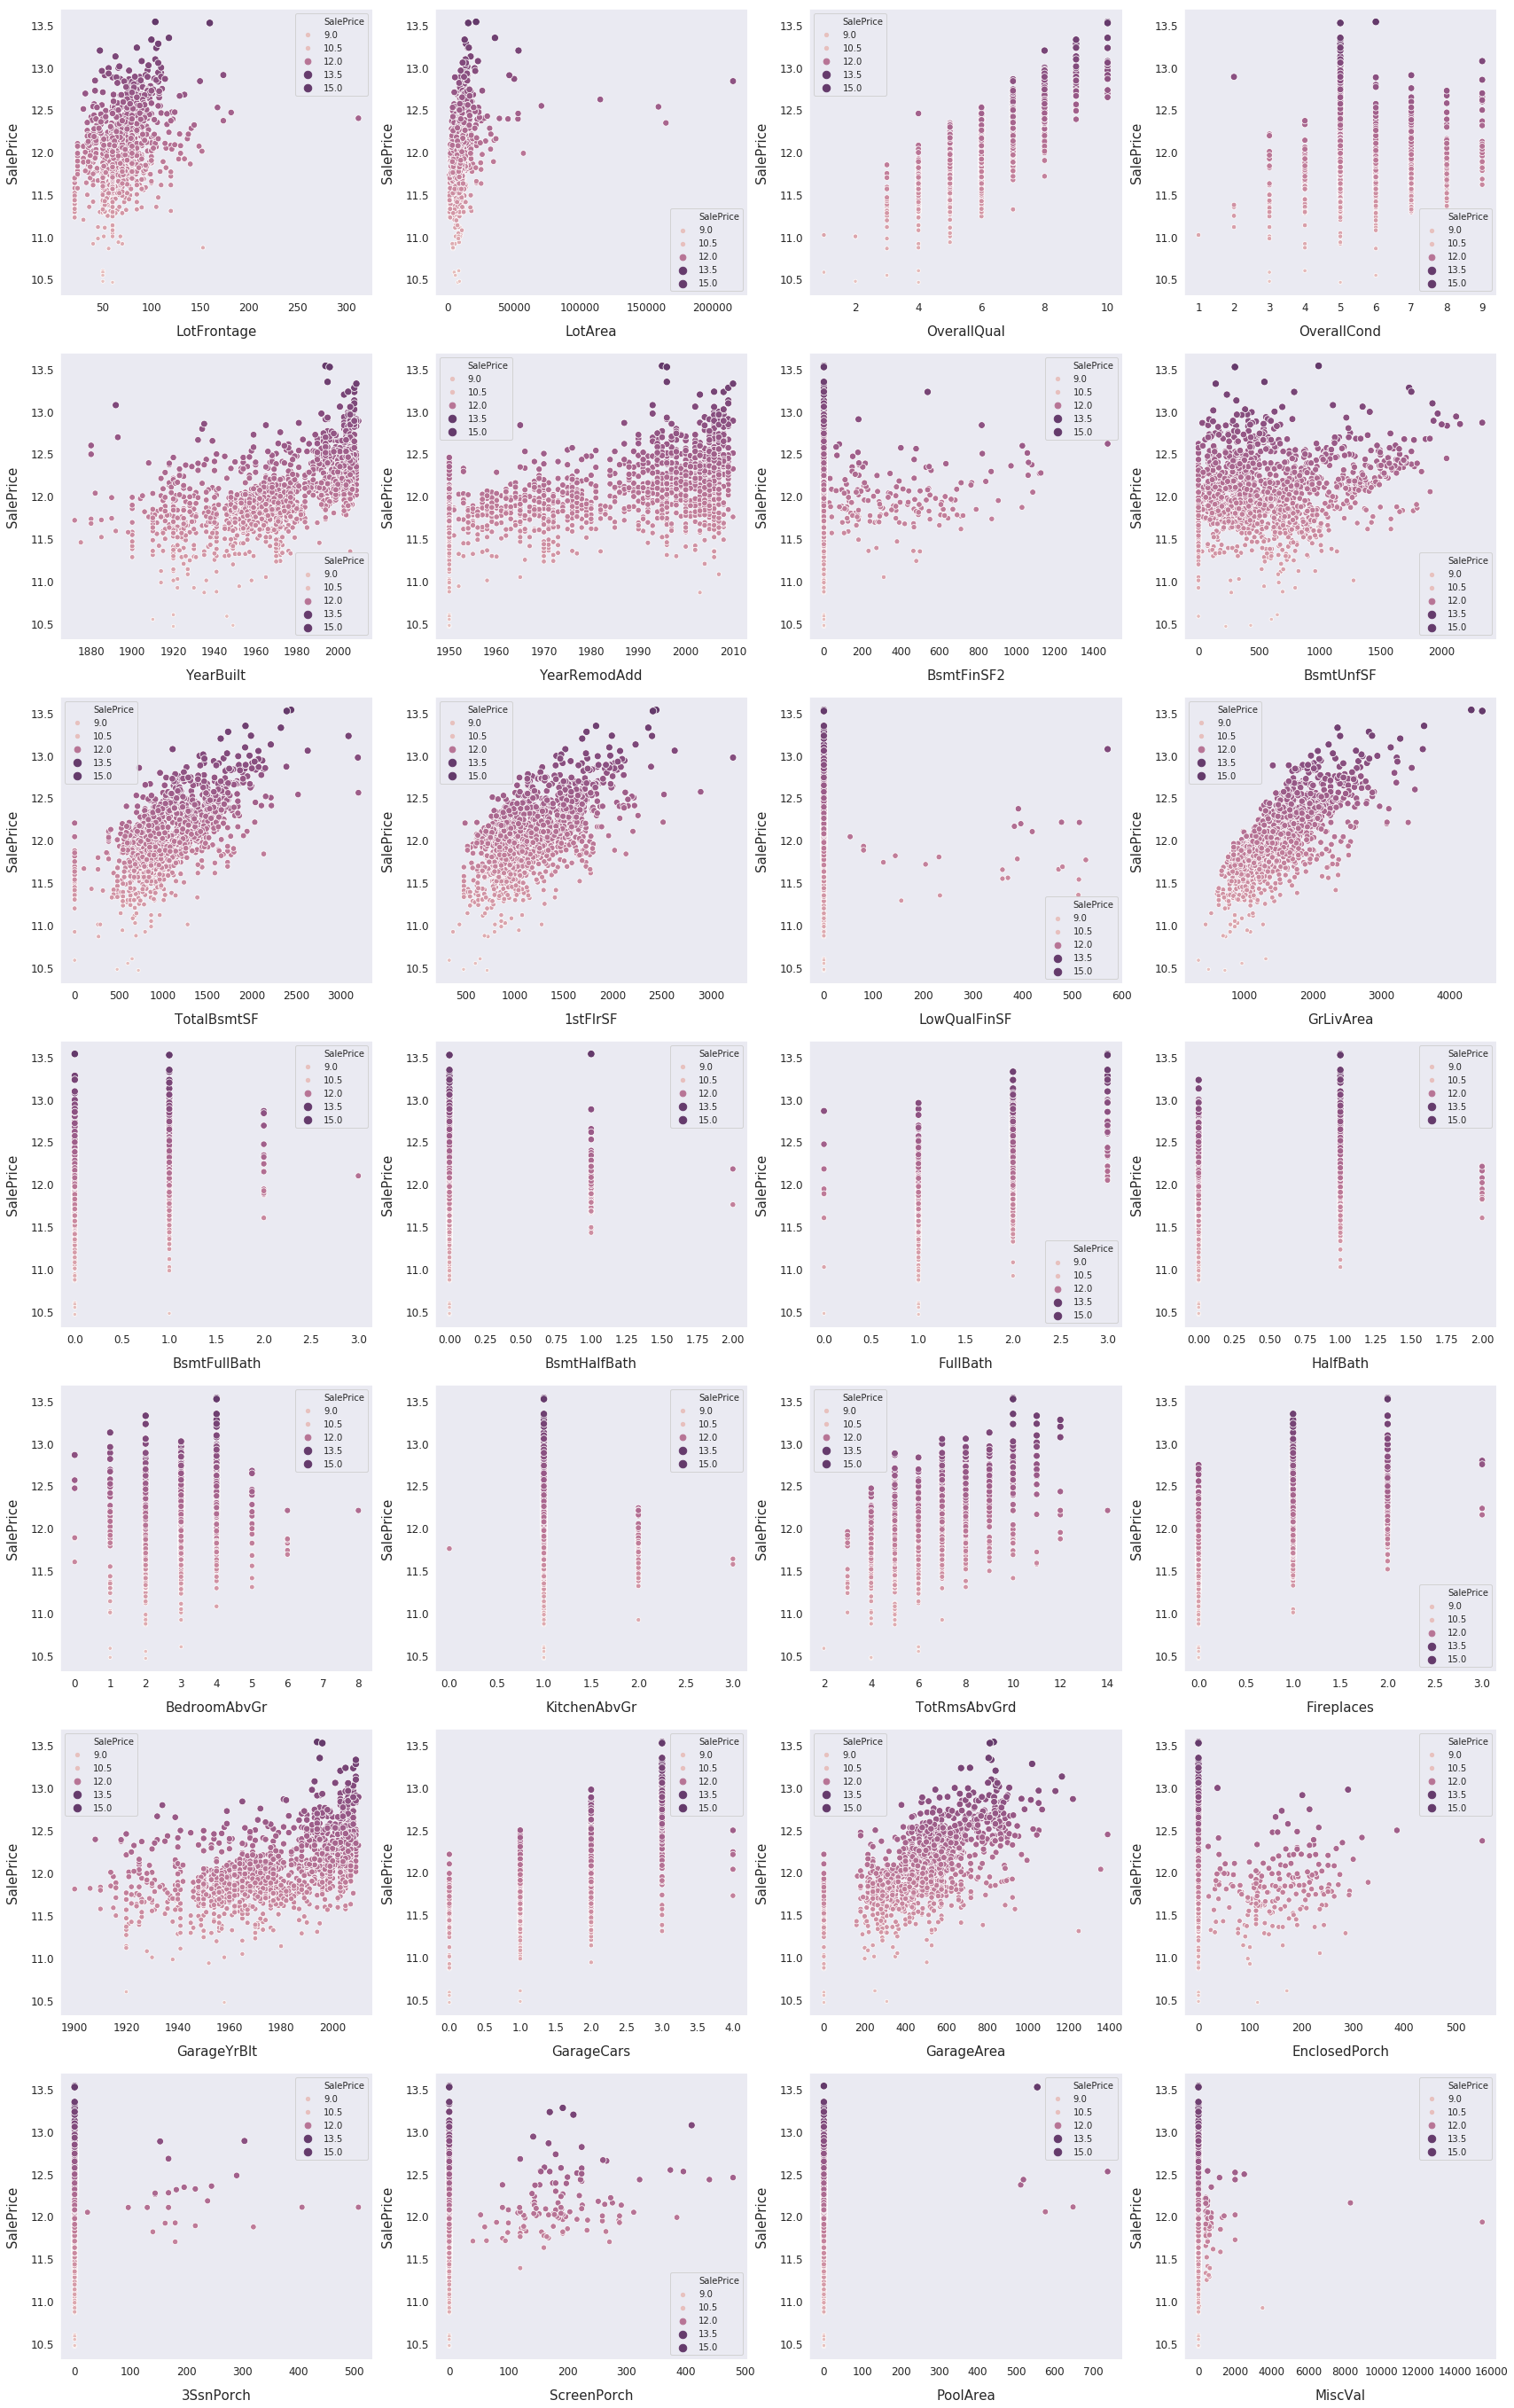

In [0]:
# Finding numeric features
sns.set_style("dark")
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics4 = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numerics4.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 80))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

cmap = sns.cubehelix_palette(dark=0.3, light=0.8, as_cmap=True)

for i, feature in enumerate(list(X[numerics4]), 1):    
    plt.subplot(len(list(numerics4)), 4, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', size='SalePrice', palette=cmap, data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()


In [0]:
# Removes outliers 
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [0]:
# Removes colums where the threshold of zero's is (> 99.95), means has only zero values 
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

X (1453, 331) y (1453,) X_test (1459, 331)


In [0]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [0]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))
# SVR : made robust to outliers
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

# gbr : made robust to outliers
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)      

# lightgbm : made robust to outliers
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
# xgboost : made robust to outliers
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
                                      
# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'svr': svr,
          'gbr': gbr,
          'lightgbm':lightgbm,
          'xgboost':xgboost }
predictions = {}
scores = {}

for name, model in models.items():
    
    model.fit(X, y)
    predictions[name] = np.expm1(model.predict(X))
    
    score = cv_rmse(model, X=X)
    scores[name] = (score.mean(), score.std())

[06:22:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:23:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:23:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
# get the performance of each model on training data(validation set)

score = cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Ridge: 0.1022 (0.0140)
 2019-06-12 06:27:24.195312
LASSO: 0.1030 (0.0145)
 2019-06-12 06:27:34.489062
elastic net: 0.1031 (0.0146)
 2019-06-12 06:28:26.431711
SVR: 0.1016 (0.0128)
 2019-06-12 06:28:38.605145
lightgbm: 0.1057 (0.0154)
 2019-06-12 06:28:55.550703
gbr: 0.1077 (0.0134)
 2019-06-12 06:30:07.919576
[06:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:02] WARNING: /workspace/src/objective/regressio

In [0]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [0]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[06:35:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:36:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
[06:38:24] WARNING: /workspace/src/obje

In [0]:
stack_score=rmsle(y, stack_gen_model.predict(np.array(X)))
stack_score

0.04506847603073167

In [0]:
# model blending function using fitted models to make predictions
def blend_models(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.30 * stack_gen_model.predict(np.array(X))))
blended_score = rmsle(y, blend_models(X))
print('RMSLE score on train data:')
print(rmsle(y, blend_models(X)))

RMSLE score on train data:
0.05745053118057148


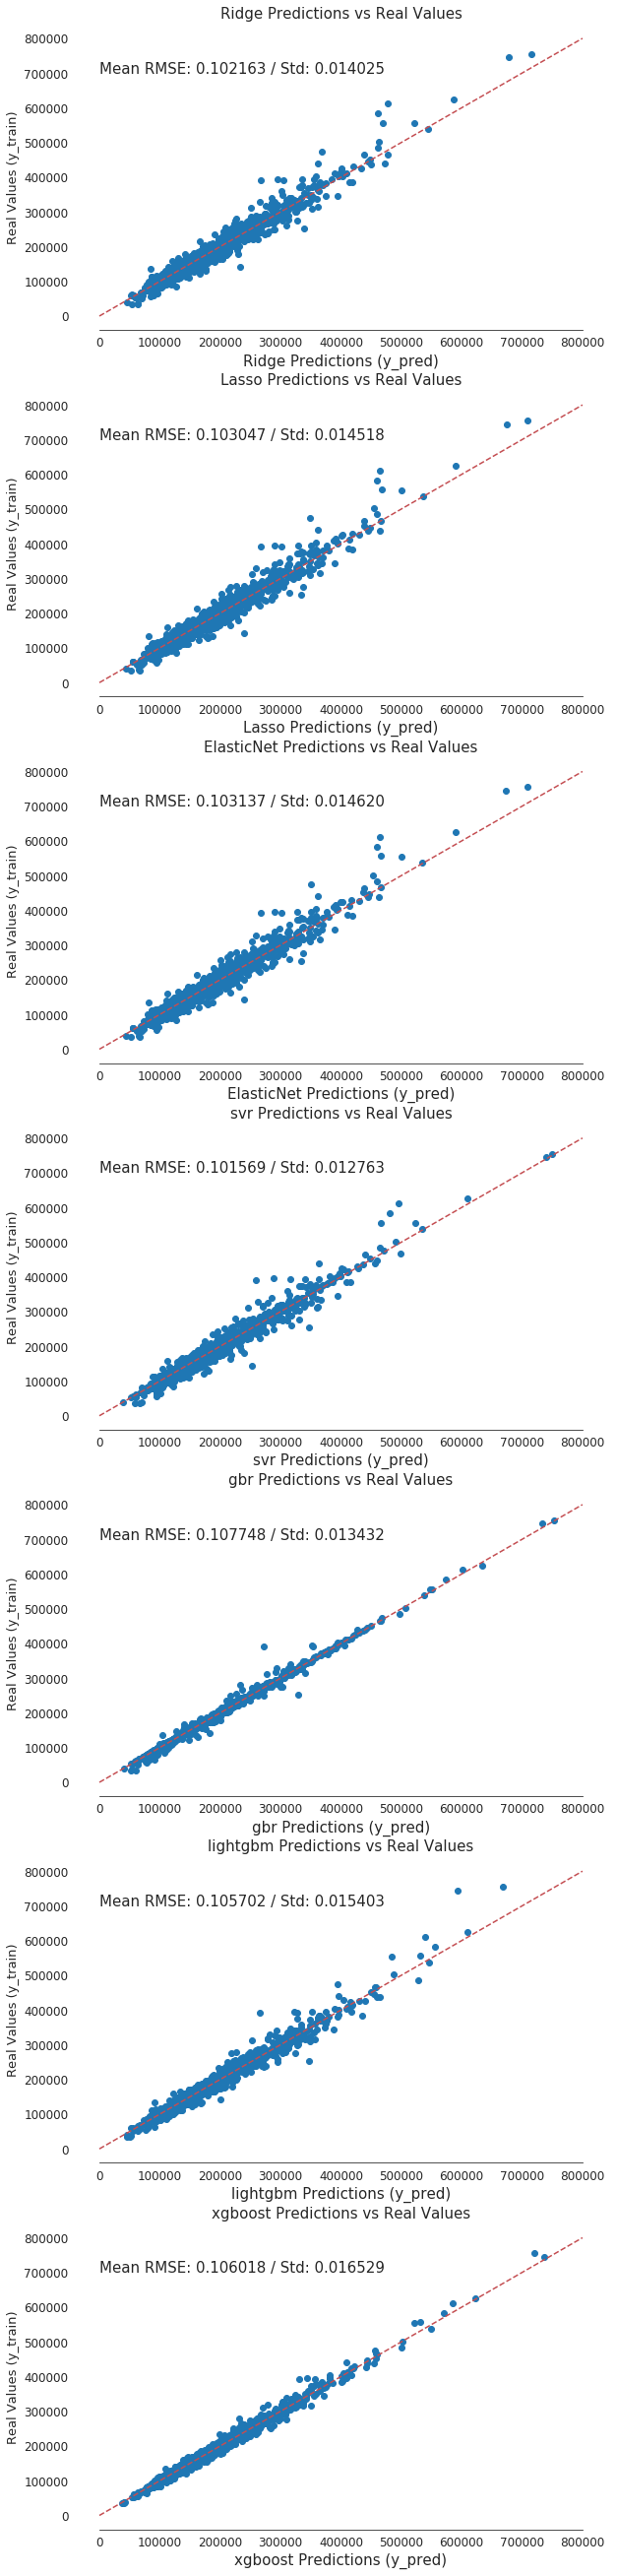

In [0]:
# visualise model performance
sns.set_style("white")
fig, axs = plt.subplots(ncols=0, nrows=8, figsize=(4, 12))
plt.subplots_adjust(top=3.5, right=2)

for i, model in enumerate(models, 1):
    plt.subplot(8, 1, i)
    plt.scatter(predictions[model], np.expm1(y))
    plt.plot([0, 800000], [0, 800000], '--r')

    plt.xlabel('{} Predictions (y_pred)'.format(model), size=15)
    plt.ylabel('Real Values (y_train)', size=13)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title('{} Predictions vs Real Values'.format(model), size=15)
    plt.text(0, 700000, 'Mean RMSE: {:.6f} / Std: {:.6f}'.format(scores[model][0], scores[model][1]), fontsize=15)
    ax.xaxis.grid(False)
    sns.despine(trim=True, left=True)
plt.show()

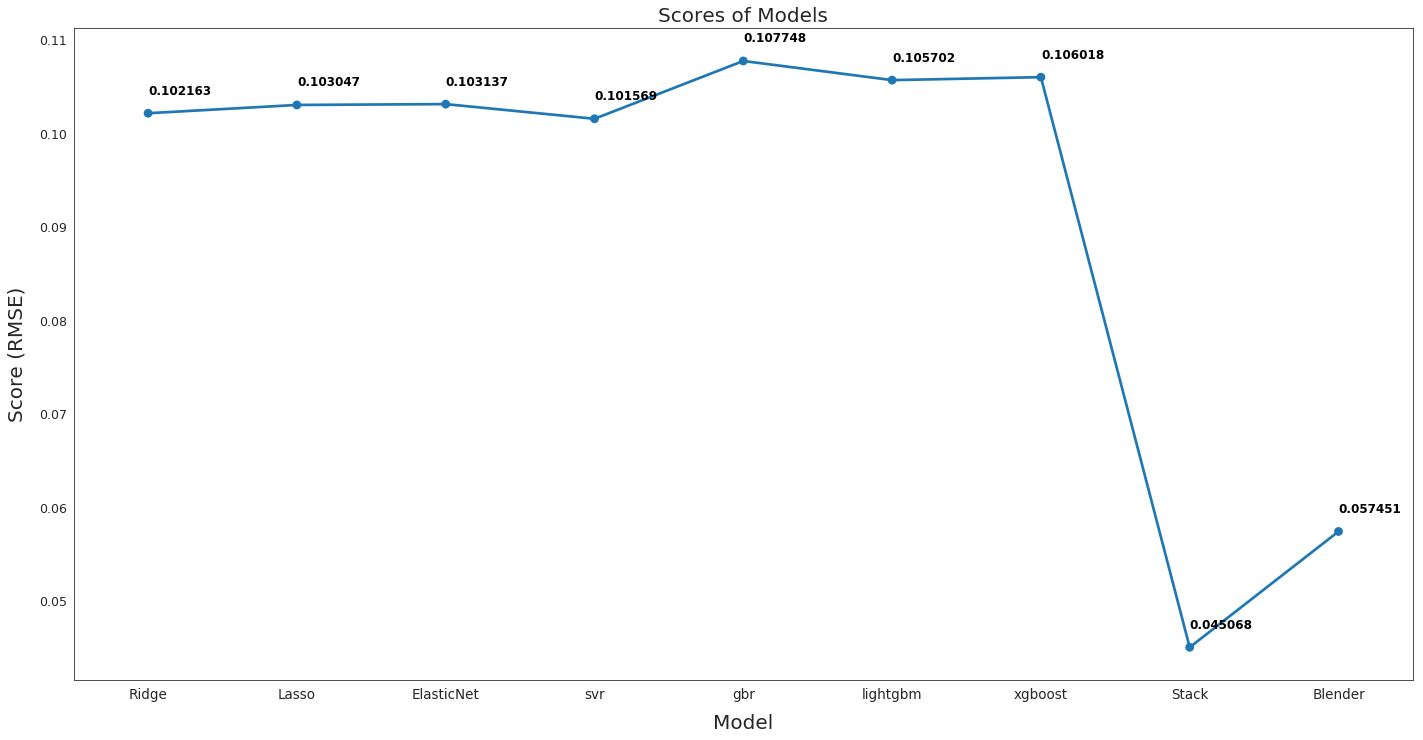

In [0]:
scores['Stack']=(stack_score, 0)
scores['Blender'] = (blended_score, 0)
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [0]:
# get the target variable/ y_test with X_test
print('Predict submission')
y_test_r = pd.read_csv("gdrive/My Drive/house-prices/sample_submission.csv")
submission = pd.read_csv("gdrive/My Drive/house-prices/sample_submission.csv")
y_test = np.log1p(y_test_r.iloc[:,1].values)
submission.iloc[:,1] = np.expm1(blend_models(X_test))
blended_score = rmsle(y_test, blend_models(X_test))


Predict submission


In [0]:
submission.to_csv("gdrive/My Drive/house-prices/new_submission.csv", index=False)
print('Save submission', datetime.now(),)

Save submission 2019-06-12 06:39:03.813734
